# Tutorial 0: Using the model

## Learning objectives

In this tutorial, we will learn how to:
- **Load a pretrained model** from the model ensemble.
- **Stimulate the model** and plot its neural responses.
- **Update its parameters** using gradient descent.

## Introduction

We built a differentiable PyTorch neural network model constrained by the motion pathway
connectome of the fly visual system. We trained our model on the task of optic flow prediction
using the computer vision dataset 'Sintel'. Since equivalently trained models differed across
runs, we characterized statistics across multiple trained models: 

**Model Ensembles**: flyvis includes ensembles of multiple independently trained models of the fly visual system. Different models in the ensemble can vary in capturing neural properties and computations, due to different initial conditions or training trajectories. Working with ensembles allows us to characterize findings statistically, in order to test their robustness across multiple models, and to explore alternative explanations.

In this tutorial, we are going to work with one model of the ensemble.

## Setup

First, let's import the necessary libraries and set up our environment:

In [ ]:
# For Google Colab, uncomment and run this cell to install flyvis
# !pip install "git+https://github.com/sjcabs/flyvis_tutorial.git"

In [2]:
# Run this to download the pretrained model ensemble
# !flyvis download-pretrained

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# flyvis imports
from flyvis import NetworkView
from flyvis.datasets.rendering import BoxEye
from flyvis.analysis.animations import HexScatter

# Set up plotting
plt.rcParams["figure.figsize"] = [5, 3]
plt.rcParams["font.size"] = 6
plt.rcParams["figure.dpi"] = 200

## Part 1: Load a pretrained model from the ensemble

Let's start by loading a pretrained model from the ensemble:

In [4]:
# Load a pretrained network model from the ensemble
# The identifier "flow/0000/000" specifies: task/ensemble_id/network_id
# - "flow": the training task (optic flow prediction)
# - "0000": the first ensemble (collection of models trained with the same configuration)
# - "000": the first network within that ensemble
network_view = NetworkView("flow/0000/000")

[2025-12-22 16:46:43] network_view:122 Initialized network view at /groups/turaga/home/stefanidiz/miniconda3/envs/flysim_tutorials/lib/python3.11/site-packages/flyvis/data/results/flow/0000/000


### Understanding the network architecture

The network models the fly visual system, including different cell types. Let's explore what cell types are available:

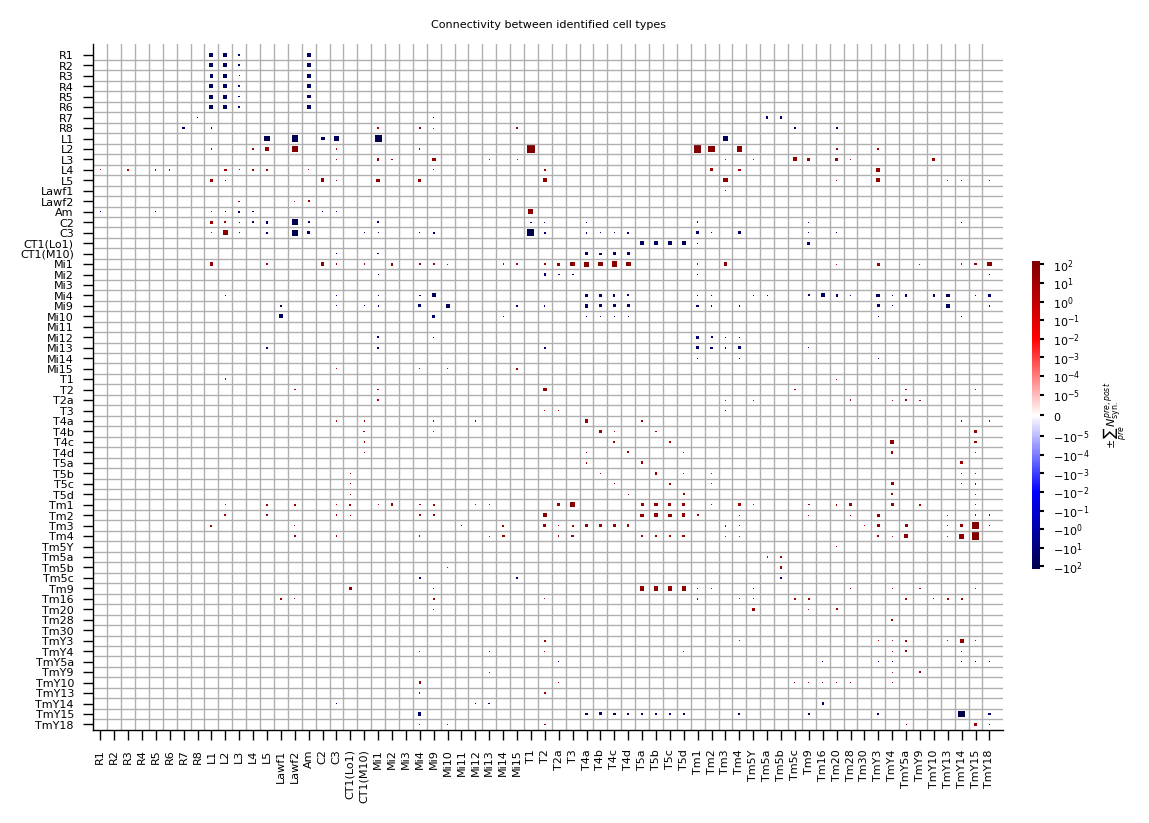

In [5]:
fig = network_view.connectivity_matrix()

In [6]:
# Get information about the network structure
connectome = network_view.connectome
cell_types = connectome.unique_cell_types

print("Available cell types:")
for i, cell_type in enumerate(cell_types):
    print(f"{i + 1:2d}. {cell_type.decode()}")

Available cell types:
 1. R1
 2. R2
 3. R3
 4. R4
 5. R5
 6. R6
 7. R7
 8. R8
 9. L1
10. L2
11. L3
12. L4
13. L5
14. Lawf1
15. Lawf2
16. Am
17. C2
18. C3
19. CT1(Lo1)
20. CT1(M10)
21. Mi1
22. Mi2
23. Mi3
24. Mi4
25. Mi9
26. Mi10
27. Mi11
28. Mi12
29. Mi13
30. Mi14
31. Mi15
32. T1
33. T2
34. T2a
35. T3
36. T4a
37. T4b
38. T4c
39. T4d
40. T5a
41. T5b
42. T5c
43. T5d
44. Tm1
45. Tm2
46. Tm3
47. Tm4
48. Tm5Y
49. Tm5a
50. Tm5b
51. Tm5c
52. Tm9
53. Tm16
54. Tm20
55. Tm28
56. Tm30
57. TmY3
58. TmY4
59. TmY5a
60. TmY9
61. TmY10
62. TmY13
63. TmY14
64. TmY15
65. TmY18


In our model, the connectivity is the same across neurons of the same type. In particular, it is the average number of synapses per column, between neurons of the presynaptic type to neurons of the postsynaptic type.

Thus the anatomical receptive and projective fields of neurons of the same cell type are shared.

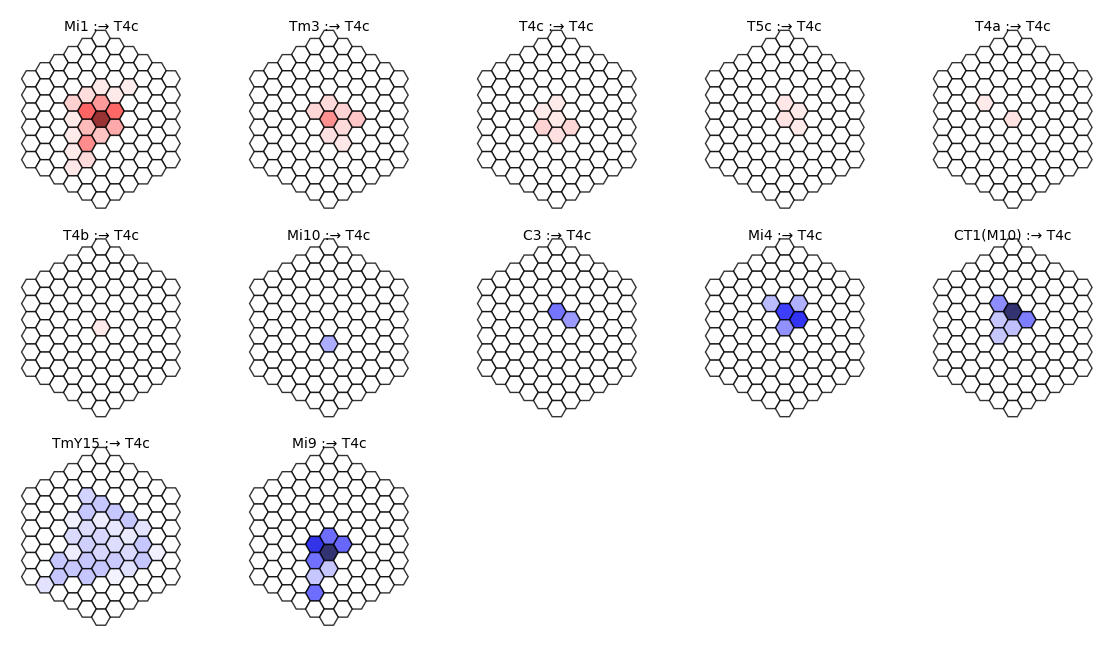

In [7]:
# Plot the anatomical receptive fields onto the central T4c cell 
# in terms of signed average number of synapses in retinotopic column space.
fig = network_view.receptive_fields_grid(
    target="T4c",
    panel_height_cm=3,
    panel_width_cm=3.6,
)
plt.subplots_adjust(wspace=0.05, hspace=0.15)

### Loading the differentiable PyTorch model

Let's load the pretrained model:

In [8]:
network_view = NetworkView(
    "flow/0000/000",
    # This loads the model with the best validation loss
    best_checkpoint_fn_kwargs={
        "validation_subdir": "validation",
        "loss_file_name": "loss",
    },
)
network = network_view.init_network()

[2025-12-22 16:46:49] network_view:122 Initialized network view at /groups/turaga/home/stefanidiz/miniconda3/envs/flysim_tutorials/lib/python3.11/site-packages/flyvis/data/results/flow/0000/000
[2025-12-22 16:46:54] network:222 Initialized network with NumberOfParams(free=734, fixed=2959) parameters.
[2025-12-22 16:46:54] chkpt_utils:36 Recovered network state.


In [9]:
# Print the network configuration
print(network.config)

Namespace(
  connectome = Namespace(
    type = 'ConnectomeFromAvgFilters',
    file = 'fib25-fib19_v2.2.json',
    extent = 15,
    n_syn_fill = 1
  ),
  dynamics = Namespace(
    type = 'PPNeuronIGRSynapses',
    activation = Namespace(type='relu')
  ),
  node_config = Namespace(
    bias = Namespace(
      type = 'RestingPotential',
      groupby = ['type'],
      initial_dist = 'Normal',
      mode = 'sample',
      requires_grad = True,
      mean = 0.5,
      std = 0.05,
      penalize = Namespace(activity=True),
      seed = 0
    ),
    time_const = Namespace(
      type = 'TimeConstant',
      groupby = ['type'],
      initial_dist = 'Value',
      value = 0.05,
      requires_grad = True
    )
  ),
  edge_config = Namespace(
    sign = Namespace(
      type = 'SynapseSign',
      initial_dist = 'Value',
      requires_grad = False,
      groupby = ['source_type', 'target_type']
    ),
    syn_count = Namespace(
      type = 'SynapseCount',
      initial_dist = 'Lognormal',
  

In [10]:
# Print the network parameters
for name, param in network.named_parameters():
    print(name, param.shape)

nodes_bias torch.Size([65])
nodes_time_const torch.Size([65])
edges_sign torch.Size([604])
edges_syn_count torch.Size([2355])
edges_syn_strength torch.Size([604])


## Part 2: Stimulate the model and plot its neural responses

Let's understand how to stimulate the model. We will start with a random stimulus.

In [11]:
from flyvis.utils.hex_utils import get_num_hexals

# Stimulation time and time step
T = 1  # seconds
dt = 1 / 50  # 1 / 200

# Create a random stimulus
stimulus = torch.randn(
    1, int(T / dt), 1, get_num_hexals(network.connectome.config.extent)
)

# Add the stimulus to a stimulus buffer
network.stimulus.add_input(stimulus)

# Run the model
with torch.no_grad():
    network_activity = network(network.stimulus(), dt=dt)

In [12]:
# Shape is (batch_size, time_steps, num_neurons)
print("Shape of the network activity:", network_activity.shape)

Shape of the network activity: torch.Size([1, 50, 45669])


Let's visualize one representative trace per cell type:

In [13]:
from flyvis.utils.activity_utils import LayerActivity as ActivityByType

# With ActivityByType one can easily access the activity all cells of a given type
# i.e. activity_by_type.T4c[:]
# or the activity of all central cells
# activity_by_type.central[:]
activity_by_type = ActivityByType(network_activity, network.connectome, keepref=True)

In [14]:
# Shape is (batch_size, time_steps, num_central_cells)
print("Shape of the activity of all central cells:", activity_by_type.central[:].shape)

Shape of the activity of all central cells: torch.Size([1, 50, 65])


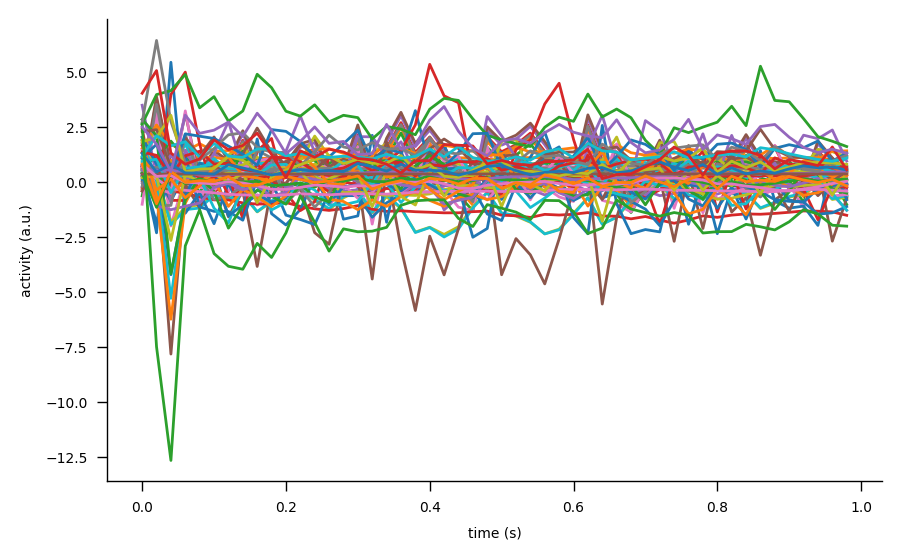

In [15]:
time = np.arange(0, network_activity.shape[1]) * dt
# plot the activity of all central cells
plt.plot(time, activity_by_type.central[:].squeeze().cpu())
plt.xlabel("time (s)")
plt.ylabel("activity (a.u.)")
plt.show()

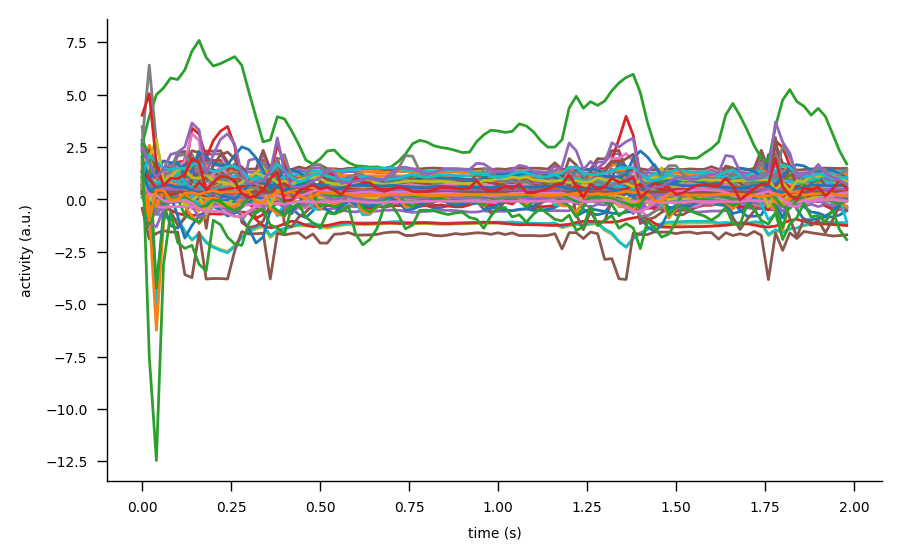

In [44]:
# Let's reduce the initial transient response by using the steady state as initial state
# initial_state = network.fade_in_state(t_fade_in=10.0, dt=dt, initial_frames=hex_frames[:,0])
initial_state = network.steady_state(t_pre=1.0, dt=dt, batch_size=1)

# Reset the stimulus buffer
network.stimulus.zero()

# Add the stimulus to a stimulus buffer
network.stimulus.add_input(stimulus)

# Run the model
with torch.no_grad():
    network_activity = network(network.stimulus(), dt=dt, state=initial_state)

# Let's visualize the activity of all central cells
time = np.arange(0, network_activity.shape[1]) * dt
plt.plot(time, activity_by_type.central[:].squeeze().cpu())
plt.xlabel("time (s)")
plt.ylabel("activity (a.u.)")
plt.show()

Now let's render a video stimulus to feed it into the model. We will use a video from the [Cowley et al. (2024)](https://www.nature.com/articles/s41586-024-07451-8) dataset, where a male fly’s visual input was approximately reconstructed based on pose estimation of both the male and a female fly during courtship.

This dataset is stored on [DANDI (Distributed Archives for Neurophysiology Data Integration)](https://dandiarchive.org/), a platform for publishing, sharing, and processing neurophysiology data. DANDI provides standardized datasets in the NWB (Neurodata Without Borders) format, making it easy to access and work with diverse neuroscience datasets. The dataset we'll use is available at [dandiset:000951](https://dandiarchive.org/dandiset/000951).

In [16]:
from flysim_tutorials.utils import download_nwb_from_dandi, list_stimulus_keys, get_stim_data, show_stim_data

# Download data from dandi
nwb_path = download_nwb_from_dandi()

# Get list of available stimuli
stimulus_keys = list_stimulus_keys(nwb_path)
print("Available stimuli:")
for i, key in enumerate(stimulus_keys):
    print(f"  {i+1:2d}. {key}")

Found 954 NWB files, version: 0.240418.2218
Already downloaded: data/000951/0.240418.2218/sub-210525/sub-210525_ses-20210525T000000_obj-m8j5s1_image+ophys.nwb
Available stimuli:
   1. nivexp_backnforth
   2. nivexp_looming
   3. nivexp_niv_angular_velocity_speed0
   4. nivexp_niv_angular_velocity_speed1
   5. nivexp_niv_angular_velocity_speed2
   6. nivexp_niv_angular_velocity_speed3
   7. nivexp_niv_looming_speed0
   8. nivexp_niv_looming_speed1
   9. nivexp_niv_looming_speed2
  10. nivexp_niv_looming_speed3
  11. nivexp_niv_sweeping_spot_radius0_speed0
  12. nivexp_niv_sweeping_spot_radius0_speed1
  13. nivexp_niv_sweeping_spot_radius0_speed2
  14. nivexp_niv_sweeping_spot_radius0_speed3
  15. nivexp_niv_sweeping_spot_radius0_speed4
  16. nivexp_niv_sweeping_spot_radius0_speed5
  17. nivexp_niv_sweeping_spot_radius0_speed6
  18. nivexp_niv_sweeping_spot_radius1_speed0
  19. nivexp_niv_sweeping_spot_radius2_speed0
  20. nivexp_niv_sweeping_spot_radius3_speed0
  21. nivexp_niv_sweeping

Stimulus shape: (1, 100, 400, 700)



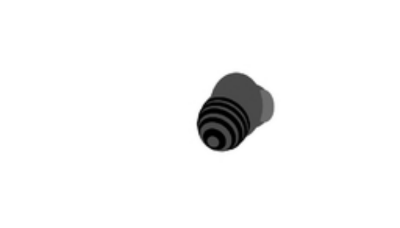

In [17]:
# Pick which stimulus to render through the hex eye
SELECTED_STIM = "nivexp_wildtype"  # <-- Change this to any stimulus you like!

# Get the stimulus data (preprocessed and ready for BoxEye)
stim_data = get_stim_data(
    stim_key=SELECTED_STIM,
    nwb_path=nwb_path,
    max_frames=100,
    pad_value=1.0,  # White padding
    # pad_value=0.5,  # White padding
)

# Let's visualize the stimulus
# Shape is (batch_size, frames, height, width)
print(f"Stimulus shape: {stim_data.shape}")
show_stim_data(stim_data, fps=30)

For rendering video stimuli, we need to load cartesian frames and render them to hexagonal coordinates:

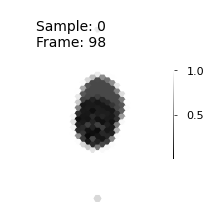

In [18]:
# Render through the hexagonal eye
renderer = BoxEye(network.connectome.config.extent, kernel_size=13)
hex_frames = renderer(stim_data)

print(f"Hex frames shape: {hex_frames.shape}")

# Visualize the hex-rendered stimulus
anim = HexScatter(hex_frames)
anim.animate_in_notebook(frames=np.arange(hex_frames.shape[1])[::2])


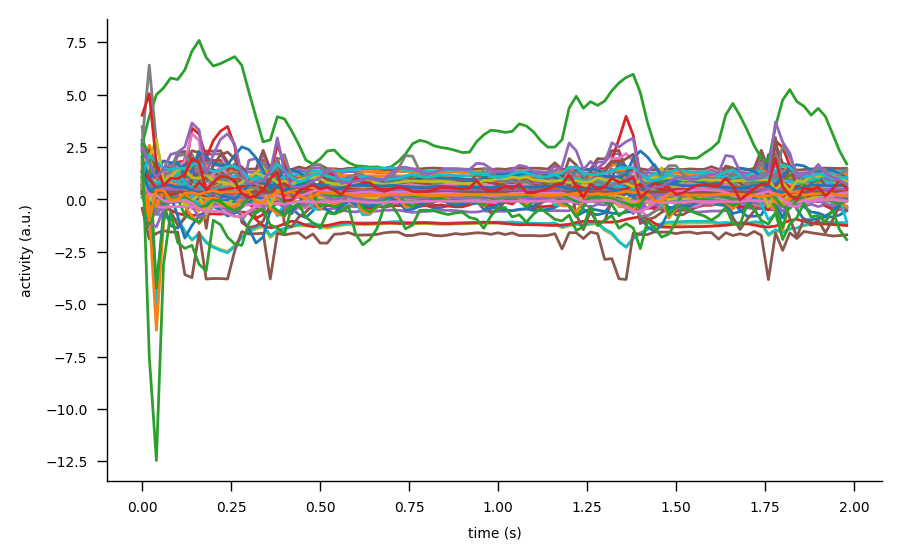

In [19]:
# Reset the stimulus buffer
network.stimulus.zero()

# Add the stimulus to a stimulus buffer
network.stimulus.add_input(hex_frames)

# Run the model
with torch.no_grad():
    network_activity = network(network.stimulus(), dt=dt)

# Get activity by type
activity_by_type = ActivityByType(network_activity, network.connectome, keepref=True)

# Let's visualize the activity of all central cells
time = np.arange(0, network_activity.shape[1]) * dt
plt.plot(time, activity_by_type.central[:].squeeze().cpu())
plt.xlabel("time (s)")
plt.ylabel("activity (a.u.)")
plt.show()

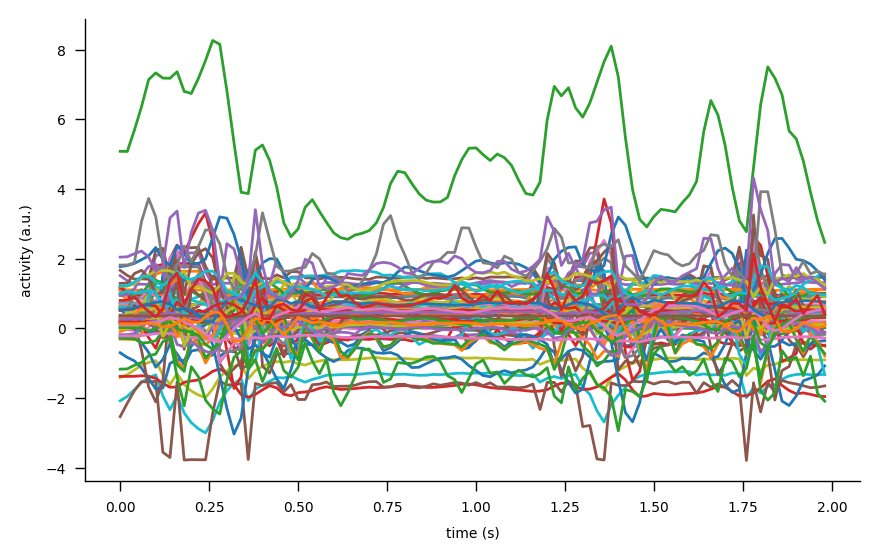

In [ ]:
# Let's reduce the initial transient response by using the steady state as initial state
initial_state = network.steady_state(t_pre=1.0, dt=dt, batch_size=1)

# Reset the stimulus buffer
network.stimulus.zero()

# Add the stimulus to a stimulus buffer
network.stimulus.add_input(hex_frames)

# Run the model
with torch.no_grad():
    network_activity = network(network.stimulus(), dt=dt, state=initial_state)

# Get activity by type
activity_by_type = ActivityByType(network_activity, network.connectome, keepref=True)

# Let's visualize the activity of all central cells
time = np.arange(0, network_activity.shape[1]) * dt
plt.plot(time, activity_by_type.central[:].squeeze().cpu())
plt.xlabel("time (s)")
plt.ylabel("activity (a.u.)")
plt.show()

## [Optional] Part 3: Gradient-descent on the model

Now let's explore how to update the model parameters using gradient descent. This is useful for training or fine-tuning the model on new data.

We'll try to increase the response of a specific neuron to our stimulus.

In [21]:
# Let's create a simple training scenario
# We'll try to increase the response of T4c neurons to our custom stimulus

# First, let's reinitialize the network to ensure we have gradients enabled
network_view = NetworkView(
    "flow/0000/000",
    best_checkpoint_fn_kwargs={
        "validation_subdir": "validation",
        "loss_file_name": "loss",
    },
)
network = network_view.init_network()

# Make sure gradients are enabled for the parameters we want to optimize
for name, param in network.named_parameters():
    if param.requires_grad:
        print(f"{name} is trainable")

# Set up an optimizer
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)

[2025-12-22 16:47:28] network_view:122 Initialized network view at /groups/turaga/home/stefanidiz/miniconda3/envs/flysim_tutorials/lib/python3.11/site-packages/flyvis/data/results/flow/0000/000


[2025-12-22 16:47:32] network:222 Initialized network with NumberOfParams(free=734, fixed=2959) parameters.
[2025-12-22 16:47:32] chkpt_utils:36 Recovered network state.


nodes_bias is trainable
nodes_time_const is trainable
edges_syn_strength is trainable


In [22]:
# Let's look at the free T4c neuron parameters of the pre-trained model
print(
    "T4c time_const (pre-trained):",
    f"{network.node_params.time_const['T4c'].item() * 1000: .0f} ms",
)
print("T4c bias (pre-trained):", f"{network.node_params.bias['T4c'].item():.2f}")
# Let's look at the free T4c input parameters, alpha_{t_i, t_j}
print(
    "\nT4c input scalings (pre-trained):",
)
for e in network.edge_params.syn_strength.keys:
    if e[1] == "T4c":
        print(f"\t{e[0]} input scaling:", f"{network.edge_params.syn_strength[e]:.8f}")

T4c time_const (pre-trained):  20 ms
T4c bias (pre-trained): 0.68

T4c input scalings (pre-trained):
	C3 input scaling: 0.01486829
	CT1(M10) input scaling: 0.01113249
	Mi1 input scaling: 0.02413530
	Mi4 input scaling: 0.05615869
	Mi9 input scaling: 0.01958211
	Mi10 input scaling: 0.07800332
	T4a input scaling: 0.03211476
	T4b input scaling: 0.06058843
	T4c input scaling: 0.06498163
	T5c input scaling: 0.02940214
	Tm3 input scaling: 0.00002163
	TmY15 input scaling: 0.01466804


In [23]:
# Create a target stimulus - let's use our video stimulus from before
dt = 1 / 50
T = 1
stimulus = hex_frames

# Find T4c neurons (we'll focus on the central ones)
t4c_indices = network.connectome.nodes.to_df().query("type == 'T4c'").index
central_t4c_idx = t4c_indices[len(t4c_indices) // 2]  # Get a central T4c neuron

print(f"Focusing on T4c neuron at index: {central_t4c_idx}")
print(f"Total T4c neurons: {len(t4c_indices)}")

# Get initial response (before training step)
network.stimulus.zero(stimulus.shape[0], stimulus.shape[1])
network.stimulus.add_input(stimulus)

with torch.no_grad():
    pretrained_activity = network(network.stimulus(), dt=dt)
    pretrained_t4c_response = pretrained_activity[0, :, central_t4c_idx]
    pretrained_peak_response = torch.max(pretrained_t4c_response).item()

print(f"Initial T4c response peak: {pretrained_peak_response:.2f}")

Focusing on T4c neuron at index: 25841
Total T4c neurons: 721
Initial T4c response peak: 2.17


In [24]:
# Training step to increase T4c response to our custom stimulus

# Clear gradients
optimizer.zero_grad()

# Forward pass
network.stimulus.add_input(stimulus)
activity = network(network.stimulus(), dt=dt)

# Get T4c response
t4c_response = activity[0, :, central_t4c_idx]

# Calculate loss as the peak response
loss = -torch.max(t4c_response)

# Backward pass
loss.backward()

# Update parameters
optimizer.step()

In [25]:
# Let's check how the T4c response changed after the training step
with torch.no_grad():
    trained_activity = network(network.stimulus(), dt=dt)
    trained_t4c_response = trained_activity[0, :, central_t4c_idx]
    trained_peak_response = torch.max(trained_t4c_response).item()
print(f"After training, T4c response peak: {trained_peak_response:.2f}")

After training, T4c response peak: 2.91


In [26]:
# Let's look at how the free T4c neuron parameters changed after the training step
print(
    "T4c time_const (after training):",
    f"{network.node_params.time_const['T4c'].item() * 1000: .0f} ms",
)
print("T4c bias (after training):", f"{network.node_params.bias['T4c'].item():.2f}")
# Let's look at the free T4c input parameters, alpha_{t_i, t_j}
print(
    "\nT4c input scalings (after training):",
)
for e in network.edge_params.syn_strength.keys:
    if e[1] == "T4c":
        print(f"\t{e[0]} input scaling:", f"{network.edge_params.syn_strength[e]:.8f}")

T4c time_const (after training):  20 ms
T4c bias (after training): 0.68

T4c input scalings (after training):
	C3 input scaling: 0.01386829
	CT1(M10) input scaling: 0.01013249
	Mi1 input scaling: 0.02513530
	Mi4 input scaling: 0.05515869
	Mi9 input scaling: 0.01858211
	Mi10 input scaling: 0.07900333
	T4a input scaling: 0.03311476
	T4b input scaling: 0.05958843
	T4c input scaling: 0.06398163
	T5c input scaling: 0.02840214
	Tm3 input scaling: 0.00102163
	TmY15 input scaling: 0.01366804


### 🤔 Discussion Questions

1. Which parameters differ after the gradient update?
2. What could this tell us about T4c inputs and function?
3. What could be other parameter changes that might increase the T4c response?

## Summary

In this tutorial, we have learned how to:

1. **Load and work with the pretrained network model** of the fly visual system
2. **Stimulate the model** with custom inputs and visualize neural responses
3. **Update model parameters** using gradient descent to optimize neural responses

### Key Insights

- `flyvis` provides pretrained connectome-constrained neural network models of the fly visual system
- Neurons in the model correspond to neurons in the fly visual system
- You can stimulate the models with custom inputs and observe neural dynamics
- Gradient descent can be used to fine-tune model parameters for specific objectives

## Supporting references

**General:**

Flyvis Documentation. https://turagalab.github.io/flyvis/.  
Lappalainen, J. K. et al. Connectome-constrained networks predict neural activity across the fly visual system. Nature 634, 1132–1140 (2024).

**Video Data:**

Cowley, B. R. et al. Mapping model units to visual neurons reveals population code for social behaviour. Nature 629, 1100–1108 (2024).
https://www.nature.com/articles/s41586-024-07451-8#Sec29

